# Token based DETHCOD

In [ ]:
%conda install -c conda-forge transformers wandb requests_cache datasets tqdm python-dotenv

In [1]:
import os
import wandb

try:
    from dotenv import load_dotenv
    # Load environment variables from .env file
    load_dotenv()

except ImportError as e:
    print(f"Error importing dotenv: {e}")


# Check if running in Colab
try:
    from google.colab import userdata
    # If running in Colab, use userdata.get to retrieve the token
    wandb.login(key=userdata.get('wandb_token'))

except ImportError:
    # If not in Colab, load the token from the environment variable
    wandb_token = os.getenv('WANDB_TOKEN')
    if wandb_token:
        wandb.login(key=wandb_token)
    else:
        print("W&B token not found in environment variable. Please set WANDB_TOKEN in your environment.")


wandb: Currently logged in as: axiom (chihuahuas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/khodabandeh/.netrc


## Download Data

In [2]:
import io
import os
import sys
import zipfile

import requests
import requests_cache
from tqdm import tqdm


zip_link = "http://www.mattmahoney.net/dc/enwik8.zip"
data_folder = "dataset"
cache_file = "download_cache"

# Ensure the data folder exists
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Initialize requests_cache
requests_cache.install_cache(os.path.join(data_folder, cache_file))

# Download the ZIP file with progress bar
response = requests.get(zip_link, stream=True)
response.raise_for_status()

# Get the total file size for the progress bar
total_size = int(response.headers.get("content-length", 0))

# Open the ZIP file from the content
with open(os.path.join(data_folder, "enwik8.zip"), "wb") as file:
    with tqdm(
        total=total_size, unit="B", unit_scale=True, desc="Downloading"
    ) as pbar:
        for data in response.iter_content(chunk_size=1024):
            file.write(data)
            pbar.update(len(data))

# Open the cached file
with open(os.path.join(data_folder, "enwik8.zip"), "rb") as file:
    # Open the ZIP file from the content
    with zipfile.ZipFile(io.BytesIO(file.read())) as zip_file:
        # Extract all contents to the data folder
        zip_file.extractall(data_folder)

print("File downloaded and decompressed successfully.", file=sys.stderr)


Downloading: 100%|███████████████████████████████████████| 36.4M/36.4M [00:00<00:00, 657MB/s]
File downloaded and decompressed successfully.


## Data

In [2]:
from datasets import load_dataset

dataset = load_dataset("text", data_files=["dataset/enwik8"])
dataset = dataset["train"]

In [3]:
from transformers import AutoTokenizer

MODEL_ID = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [4]:
# Removing large and empty samples
MAX_LENGTH = 128

def filter_samples(example):
    tokenized = tokenizer(
        example["text"],
        truncation=True,
        max_length=MAX_LENGTH + 1,
        return_attention_mask=False,
        return_length=True,
    )

    return [
        1 < sample_length <= MAX_LENGTH
        for sample_length in tokenized.length
    ]

dataset = dataset.filter(filter_samples, batched=True)

In [5]:
import random
sample = random.choice(dataset)
print(repr(sample["text"]))

'|-'


## Model

In [6]:
from dataclasses import dataclass
from typing import Optional, Tuple, Union

import torch
import torch.nn as nn
import transformers
import transformers.modeling_outputs


class CompressionConfig(transformers.T5Config): ...


@dataclass
class CompressionOutput(transformers.modeling_outputs.Seq2SeqLMOutput):
    value_predictions: Optional[Tuple[torch.FloatTensor, ...]] = None


class CompressionModel(transformers.T5ForConditionalGeneration):
    def __init__(self, config):
        super().__init__(config)

        # Increase the critic_head model size
        self.critic_head = nn.Linear(config.d_model, 1)
        self.critic_head.weight.data.normal_(mean=0.0, std=(1 / config.d_model))
        self.critic_head.bias.data.zero_()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        decoder_head_mask: Optional[torch.FloatTensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = True,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.FloatTensor], CompressionOutput]:
        output = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            encoder_outputs=encoder_outputs,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            labels=labels,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if output.decoder_hidden_states is not None:
            # TODO: Check if this is actually last layer
            last_hidden_state = output.decoder_hidden_states[-1]
            value_predictions = self.critic_head(last_hidden_state).squeeze(-1)
        else:
            value_predictions = None

        return CompressionOutput(
            value_predictions=value_predictions,
            logits=output.logits,
            past_key_values=output.past_key_values,
            decoder_hidden_states=output.decoder_hidden_states,
            decoder_attentions=output.decoder_attentions,
            cross_attentions=output.cross_attentions,
            encoder_last_hidden_state=output.encoder_last_hidden_state,
            encoder_hidden_states=output.encoder_hidden_states,
            encoder_attentions=output.encoder_attentions,
        )


In [7]:
import transformers
import transformers.modeling_outputs


class DecompressionConfig(transformers.T5Config): ...


class DecompressionModel(transformers.T5ForConditionalGeneration): ...

In [8]:
from pathlib import Path

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_PATH = Path("./data/models/token-dethcod/a2c-v1")

### Load Model

In [9]:
LOAD_LATEST = False

if LOAD_LATEST:
    compressor = CompressionModel.from_pretrained(MODEL_PATH / "compressor").to(device)
    decompressor = DecompressionModel.from_pretrained(MODEL_PATH / "decompressor").to(device)

else:
    model_path = "google-t5/t5-small"
    print(f"Loading model from {model_path}")
    compressor = CompressionModel.from_pretrained(model_path).to(device)
    compressor.critic_head.reset_parameters()
    decompressor = DecompressionModel.from_pretrained(model_path).to(device)

Loading model from google-t5/t5-small


Some weights of CompressionModel were not initialized from the model checkpoint at google-t5/t5-small and are newly initialized: ['critic_head.bias', 'critic_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train

In [10]:
import wandb

wandb.init(
    name = "Token Training",
    project="DETHCOD",
    config={
        "compressor_model_config": compressor.config.to_dict(),
        "decompressor_model_config": decompressor.config.to_dict(),
    },
)

In [11]:
LR = 1e-5

compressor_optimizer = torch.optim.Adam(compressor.parameters(), lr=LR)
decompressor_optimizer = torch.optim.Adam(decompressor.parameters(), lr=LR)

In [12]:
import math

BATCH_SIZE = 8
REWARD_SCALING = 0.01
MAX_TOKEN_COST = math.log(compressor.config.vocab_size)

train_dataset = dataset
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

SCHEDULING_STEPS = len(data_loader) * 1.0e-2 # Schedule over 1% of an epoch
PRETRAINING_STEPS = len(data_loader) * 2.0e-2 # Schedule over 2% of an epoch

In [13]:
class TokenCostScheduler:
    def __init__(self, total_steps, max_token_cost, schedule_fn=None):
        self.total_steps = total_steps
        self.max_token_cost = max_token_cost
        self.step_count = 0

        linear_schedule = lambda self: min(self.step_count / self.total_steps, 1.0) * self.max_token_cost
        # If no schedule function is provided, default to linear schedule
        self.schedule_fn = schedule_fn if schedule_fn else linear_schedule

    def get_token_cost(self):
        # Get the current token cost based on the schedule
        token_cost = self.schedule_fn(self)
        self.step_count += 1  # Increment the step count
        return token_cost

### RL Training Loop

In [ ]:
import torch.nn.functional as F
import tqdm.auto as tqdm
from transformers import GenerationConfig
from transformers import modeling_outputs


# Define your generation configuration as before
generation_config = GenerationConfig(
    do_sample=True,
    num_beams=1,
    max_new_tokens=128,
    decoder_start_token_id=compressor.generation_config.decoder_start_token_id,
    eos_token_id=compressor.generation_config.eos_token_id,
    pad_token_id=compressor.generation_config.pad_token_id,
    return_dict_in_generate=True,
    output_logits=True,
)

# Initialize the scheduler
token_cost_scheduler = TokenCostScheduler(total_steps=SCHEDULING_STEPS, max_token_cost=MAX_TOKEN_COST)

with tqdm.tqdm(data_loader) as pbar:
    for step, batch in enumerate(pbar):
        # Get the current token cost from the scheduler
        token_cost = token_cost_scheduler.get_token_cost()

        input_ids = tokenizer(
            batch["text"],
            return_tensors="pt",
            padding=True,
            # TODO: Test if this has any effect
            truncation=True,
        ).input_ids.to(device)

        compressed = compressor.generate(input_ids=input_ids, generation_config=generation_config)
        decompressed = decompressor.forward(input_ids=compressed.sequences, labels=input_ids)

        full_episodes = (compressed.sequences != generation_config.eos_token_id).all(dim=-1)
        sequences_copy = compressed.sequences.clone()
        sequences_copy[..., full_episodes, -1] = generation_config.eos_token_id
        compressed.sequences = sequences_copy

        actions = compressed.sequences[..., 1:]
        # compressed.logits: [
        #      torch.tensor(shape=(B, V))
        # ]
        # (L, B, V)
        # (B, L, V)
        action_distributions = torch.stack(compressed.logits).transpose(0, 1)
        values = compressor.forward(input_ids=input_ids, decoder_input_ids=compressed.sequences).value_predictions[..., :-1]
        action_mask = actions != generation_config.pad_token_id
        is_pad = actions == generation_config.pad_token_id
        is_eos = actions == generation_config.eos_token_id
        compressed_length = actions.size(-1) - is_pad.logical_or(is_eos).sum(dim=-1)

        losses = F.cross_entropy(
            decompressed.logits.flatten(0, -2),
            target=input_ids.flatten(),
            ignore_index=0,
            reduction="none",
        ).view(input_ids.shape)
        decompressor_loss = losses.mean()

        sequence_compression_loss = losses.detach().sum(dim=-1)
        rewards = torch.where(
            actions == generation_config.eos_token_id,
            -sequence_compression_loss.unsqueeze(-1),
            -token_cost,
        ) * action_mask * REWARD_SCALING
        # TODO: Implement temporal difference learning
        qs = rewards.flip(dims=[-1]).cumsum(dim=-1).flip(dims=[-1])

        advantage = (qs - values) * action_mask
        num_actions = action_mask.sum()
        expected_advantage = advantage.sum() / num_actions
        critic_loss = (advantage * advantage).sum() / num_actions

        data_costs = torch.where(
            actions == generation_config.eos_token_id,
            sequence_compression_loss.unsqueeze(-1),
            MAX_TOKEN_COST,
        ) * action_mask
        compressed_size = data_costs.sum(dim=-1)
        decompressed_size = (input_ids != 0).sum(dim=-1) * MAX_TOKEN_COST
        compression_ratio = (decompressed_size / compressed_size).mean()

        if step < PRETRAINING_STEPS:
            # Train the model to generate the original sequence
            actor_loss = super(CompressionModel, compressor).forward(input_ids=input_ids, labels=input_ids).loss

        else:
            # [x] | x \in R
            # b = -ln(\sigma e^x)
            # norm = [x + b][action]
            # al = x[action] - ln(sigma(e^x))
            #    = ln(e^x[action]) - ln(sigma(e^x))
            #    = ln(e^x[action]/sigma(e^x))

            # cross entropy = -ln(e^x[action]/sigma(e^x))
            action_logits = F.cross_entropy(
                action_distributions.flatten(0, -2),
                target=actions.flatten(),
                ignore_index=0,
                reduction="none",
            ).view(actions.shape)
            actor_loss = (action_logits * advantage.detach()).mean()

        compressor_loss = actor_loss + critic_loss

        pbar.set_description(f"{compression_ratio=:.2f}, {critic_loss=:.2f}, {actor_loss=:.2f}, {decompressor_loss=:.2f}")

        compressor_optimizer.zero_grad()
        compressor_loss.backward()
        compressor_optimizer.step()

        decompressor_optimizer.zero_grad()
        decompressor_loss.backward()
        decompressor_optimizer.step()

        with torch.no_grad():
            wandb.log(
                {
                    "actor_loss": actor_loss,
                    "critic_loss": critic_loss,
                    "reward": rewards.sum(dim=-1).mean(),
                    "decompressor_loss": decompressor_loss,
                    "accuracy": (-sequence_compression_loss).exp().mean(),
                    "compressed_size": compressed_length.float().mean(),
                    "compression_ratio": compression_ratio,
                    "expected_advantage": expected_advantage,
                    "token_cost": token_cost,
                }
            )


  0%|          | 0/106887 [00:00<?, ?it/s]

In [17]:
wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f661ee17b60>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f6618119ee0, raw_cell="wandb.finish()" store_history=True silent=False shell_futures=True cell_id=e315135b-0bfa-437f-915f-f68e9ef6a1fd>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt



Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f661ee17b60>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f66181181a0, execution_count=17 error_before_exec=None error_in_exec=Permission denied to access chihuahuas/DETHCOD/vn3qp0iz info=<ExecutionInfo object at 7f6618119ee0, raw_cell="wandb.finish()" store_history=True silent=False shell_futures=True cell_id=e315135b-0bfa-437f-915f-f68e9ef6a1fd> result=None>,),kwargs {}:


KeyboardInterrupt: 

### Save

In [61]:
compressor.save_pretrained(MODEL_PATH / "compressor")

In [62]:
decompressor.save_pretrained(MODEL_PATH / "decompressor")

## Playground

In [ ]:
token_cost

In [14]:

super(CompressionModel, compressor).forward(input_ids=input_ids, labels=input_ids).loss

tensor(0.4424, device='cuda:1', grad_fn=<NllLossBackward0>)

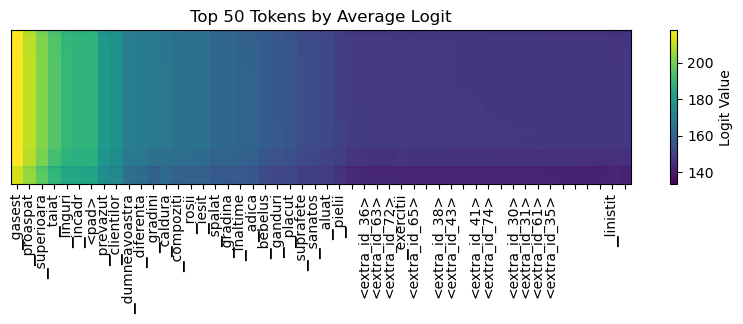

In [21]:
import torch
import matplotlib.pyplot as plt

# Assuming `action_distributions` is the tensor of shape [100, 32128]
logits = action_distributions[1].detach().cpu()  # Ensure it's on the CPU

# Step 1: Average the logits across the first axis (dimension 0)
avg_logits = torch.mean(logits, dim=0)

# Step 2: Get the top 50 tokens based on average logit values
top_values, top_indices = torch.topk(avg_logits, 50)

# Step 3: Convert the top indices to tokens using the tokenizer
top_tokens = tokenizer.convert_ids_to_tokens(top_indices.numpy())

# Step 4: Plot the top 50 logits using imshow with tokens as labels
plt.figure(figsize=(10, 2))
plt.imshow(logits[..., top_indices].numpy(), cmap='viridis', aspect='auto', interpolation="nearest")
plt.colorbar(label='Logit Value')
plt.yticks([])  # Hide y-axis as we only have one row
plt.xticks(range(50), top_tokens, rotation='vertical')
plt.title('Top 50 Tokens by Average Logit')
plt.show()


In [57]:
advantage

tensor([[ 1.6071e+01,  1.4467e+01,  1.3223e+01,  1.1192e+01,  1.2668e+01,
          1.4822e+01,  1.6281e+01,  1.6839e+01,  1.7466e+01,  1.7355e+01,
          1.6029e+01,  1.6101e+01,  1.8090e+01,  1.7498e+01,  1.6695e+01,
          1.5920e+01,  1.6476e+01,  1.6056e+01,  1.5791e+01,  1.3488e+01,
          1.4407e+01,  1.3761e+01,  1.5285e+01,  1.4266e+01,  1.0507e+01,
          1.1722e+01,  1.1522e+01,  9.8433e+00,  9.4221e+00,  8.8032e+00,
          9.3354e+00,  9.7333e+00,  9.5123e+00,  9.4863e+00,  1.0400e+01,
          9.4918e+00,  9.4040e+00,  8.7492e+00,  9.1167e+00,  1.0707e+01,
          1.0289e+01,  1.0731e+01,  9.9922e+00,  9.0388e+00,  9.8810e+00,
          1.1471e+01,  1.1771e+01,  1.2590e+01,  1.2384e+01,  1.1033e+01,
          1.0945e+01,  1.2145e+01,  1.3127e+01,  1.4587e+01,  1.4495e+01,
          1.2503e+01,  1.1677e+01,  1.1761e+01,  1.3001e+01,  1.0543e+01,
          1.0493e+01,  1.1536e+01,  1.1496e+01,  8.8739e+00,  7.8339e+00,
          8.7004e+00,  1.1088e+01,  1.

In [54]:
action_mask.sum()

tensor(200, device='cuda:1')

In [55]:
action_logits

tensor([[9.2983e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         2.3842e-07, 9.5367e-07, 2.8610e-06, 8.1062e-06, 1.3590e-05, 2.7775e-05,
         8.0701e-05, 2.9488e-04, 8.9534e-04, 2.2504e-03, 3.2974e-03, 6.3756e-03,
         1.6895e-02, 6.8286e-02, 2.1855e-01, 5.3514e-01, 8.1005e-01, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 

In [49]:
values[0], qs[0]

(tensor([-1099.6810, -1087.6995, -1076.0786, -1063.6698, -1054.7687, -1046.5447,
         -1037.6260, -1027.8066, -1018.0566, -1007.5678,  -995.8646,  -985.5587,
          -977.1706,  -966.2009,  -955.0208,  -943.8681,  -934.0468,  -923.2490,
          -912.6065,  -899.9257,  -890.4675,  -879.4435,  -870.5907,  -859.1940,
          -845.0573,  -835.8955,  -825.3179,  -813.2614,  -802.4627,  -791.4663,
          -781.6210,  -771.6415,  -761.0430,  -750.6395,  -741.1759,  -729.8900,
          -719.4247,  -708.3924,  -698.3824,  -689.5949,  -678.8000,  -668.8644,
          -657.7481,  -646.4171,  -636.8819,  -628.0941,  -618.0164,  -608.4584,
          -597.8752,  -586.1464,  -575.6812,  -566.5031,  -557.1078,  -548.1906,
          -537.7205,  -525.3519,  -514.1478,  -503.8547,  -494.7173,  -481.8814,
          -471.4543,  -462.1197,  -451.7022,  -438.7026,  -427.2851,  -417.7741,
          -409.7844,  -398.9852,  -388.6053,  -377.3386,  -367.8718,  -357.7217,
          -345.6424,  -336.0

In [56]:
action_distributions

tensor([[[ 42.5565,  -7.8072,  29.3323,  ..., -32.0589, -33.0385, -35.3182],
         [ 23.7275,  -6.8322,  26.1425,  ..., -38.0214, -39.0071, -41.5004],
         [ 27.3845, -11.7691,  26.7946,  ..., -36.9438, -37.9392, -40.4390],
         ...,
         [  8.6169, -19.3931, -13.6451,  ..., -45.4590, -46.8009, -46.7714],
         [  9.2576, -19.5066, -13.6655,  ..., -45.5242, -46.8551, -46.8182],
         [ 10.3809, -21.2369, -14.6508,  ..., -45.2848, -46.5306, -46.4914]],

        [[ 37.7327,  -5.0951,  26.8845,  ..., -32.0686, -33.0935, -35.2686],
         [ 18.1861,  -3.8062,  25.1262,  ..., -38.5185, -39.5455, -41.9225],
         [ 20.0888,  -9.5134,  26.6477,  ..., -37.9658, -38.9319, -41.2657],
         ...,
         [  7.4155, -23.2394, -13.5891,  ..., -48.8296, -50.1104, -50.0522],
         [  7.9775, -23.4906, -13.4194,  ..., -48.8065, -50.0781, -50.0124],
         [  9.0720, -25.4228, -14.5521,  ..., -48.0591, -49.2677, -49.1962]]],
       device='cuda:1')

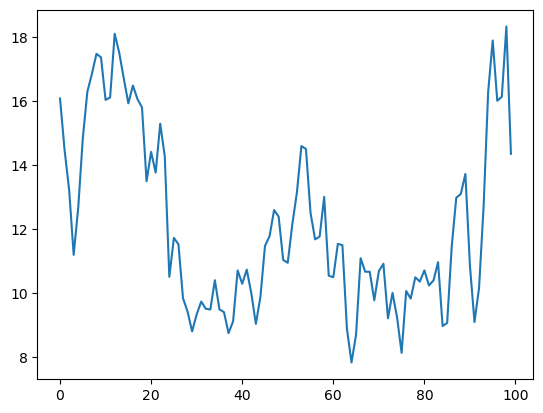

In [51]:
plt.plot(advantage[0].cpu().detach())

In [ ]:
import random

sample = random.choice(dataset)
print(repr(sample["text"]))

input_ids = tokenizer(
    batch["text"],
    return_tensors="pt",
    padding=True,
    truncation=True,
).input_ids.to(device)

with torch.no_grad():
    compressed = compressor.generate(input_ids=input_ids, generation_config=generation_config)
    print(repr(tokenizer.decode(compressed.sequences[0])))
    decompressed = decompressor.forward(input_ids=compressed.sequences, labels=input_ids)

actions = compressed.sequences[..., 1:]
action_distributions = torch.stack(compressed.logits).transpose(0, 1)
values = compressor.forward(input_ids=input_ids, decoder_input_ids=compressed.sequences).value_predictions[..., :-1]
action_mask = actions != generation_config.pad_token_id
is_pad = actions == generation_config.pad_token_id
is_eos = actions == generation_config.eos_token_id
compressed_length = actions.size(-1) - is_pad.logical_or(is_eos).sum(dim=-1)

losses = F.cross_entropy(
    decompressed.logits.flatten(0, -2),
    target=input_ids.flatten(),
    ignore_index=0,
    reduction="none",
).view(input_ids.shape)
decompressor_loss = losses.mean()

sequence_compression_loss = losses.detach().sum(dim=-1)
rewards = torch.where(
    actions == generation_config.eos_token_id,
    -sequence_compression_loss.unsqueeze(-1),
    -TOKEN_COST,
) * action_mask
qs = rewards.flip(dims=[-1]).cumsum(dim=-1).flip(dims=[-1])

advantage = (qs - values) * action_mask
critic_loss = (advantage * advantage).mean()

action_logits = F.cross_entropy(
    action_distributions.flatten(0, -2),
    target=actions.flatten(),
    ignore_index=0,
    reduction="none",
).view(actions.shape)
actor_loss = (action_logits * advantage.detach()).mean()

print(f"actor_loss={actor_loss}")
print(f"critic_loss={critic_loss}")
print(f"reward={rewards.sum(dim=-1).mean()}")
print(f"decompressor_loss={decompressor_loss}")
print(f"accuracy={(-losses.sum(dim=-1)).exp().mean()}")
print(f"compressed_size={compressed_length.float().mean()}")

In [ ]:
actions[2][4] = 1

In [ ]:
actions

In [ ]:
_61.tolist()

In [ ]:
tokenizer.decode(compressed[0])

In [ ]:
action_logits

In [ ]:
compressed[0, 1] = 4

In [ ]:
values, indices = compression_output.logits[0, -1].sort(descending=True)

In [ ]:
indices

In [ ]:
F.cross_entropy(
    compression_output.logits[:, :-1, :].view(-1, num_ids),
    target=compressed[:, 1:].flatten(),
    ignore_index=0,
    reduction='none',
) * advantage.flatten()

In [ ]:
compression_output.keys()

In [ ]:
len(action_logits)

In [ ]:
compressed

In [ ]:
sample["text"]

In [ ]:
advantage

In [ ]:
losses

In [ ]:
reward

In [ ]:
len_compressed

In [ ]:
advantage

In [ ]:
actor_loss

In [ ]:
critic_loss